# Inisiasi Program

## Instalasi dan impor library

In [ ]:
!pip install wordcloud
!pip install tensorflow
!pip install seaborn
!pip install imblearn

In [1]:
# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

# Library untuk preprocessing data
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Library untuk model building
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Library untuk evaluasi model
from sklearn.metrics import classification_report, confusion_matrix

## Impor dataset

In [2]:
# Nama file yang sudah di-upload
nama_file = 'Data.csv'

# Membaca file CSV dengan encoding yang berbeda
try:
    df = pd.read_csv(nama_file, encoding='utf-8')
except UnicodeDecodeError:
    print("UTF-8 decoding failed, trying latin-1...\n")
    df = pd.read_csv(nama_file, encoding='latin-1')


# Menampilkan informasi umum
print("Informasi Umum Dataset:")
df.info()

UTF-8 decoding failed, trying latin-1...

Informasi Umum Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23644 entries, 0 to 23643
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      23644 non-null  object
 1   sentiment  23644 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 369.6+ KB


# Preproses Data

## Filter dan Rename Data Records

In [3]:
# Hanya ambil sentimen positif dan negatif (tidak mengambil netral)
df = df[df['sentiment'].isin([1, 2])].reset_index(drop=True)

# Rename sentimen angka menjadi teks
df['sentiment'] = df['sentiment'].map({1: 'Positif', 2: 'Negatif'})

# Tampilkan contoh dataset yang telah diubah
df.head()

,Tweet,sentiment
0,Ketahui informasi pembagian #PPKM di wilayah J...,Positif
1,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,Positif
2,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",Positif
3,Ketahui informasi pembagian #PPKM di wilayah J...,Positif
4,Kementerian Agama menerbitkan Surat Edaran Nom...,Positif


## Visualisasi Distribusi Kata pada Raw Data

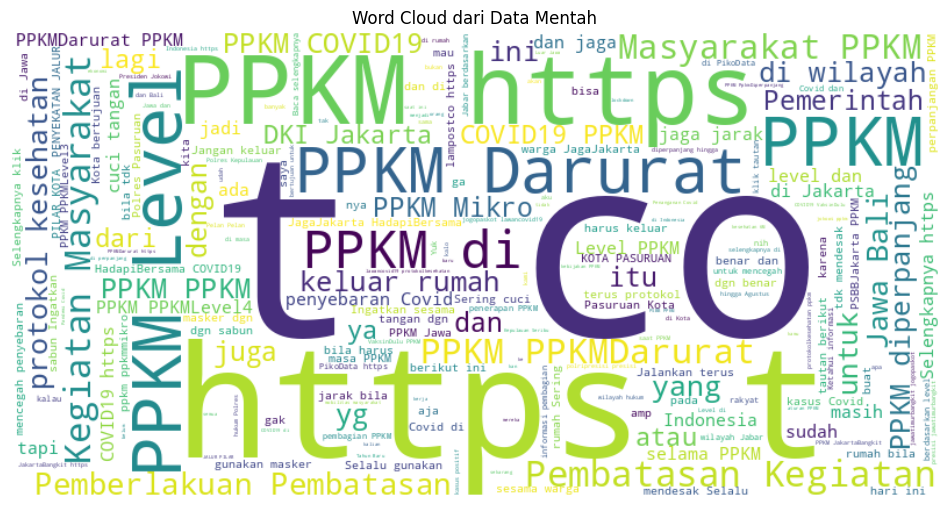

In [4]:
# Gabungkan semua teks mentah menjadi satu string besar
raw_text = " ".join(df['Tweet'].astype(str))

# Gunakan wordcloud untuk visualisasi distribusi kata
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(raw_text)

# Plot wordcloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Data Mentah')
plt.show()

Berdasarkan visualisasi di atas, teks masih banyak mengandung kata kata kurang bermakna seperti tautan/link atau stopwords. Maka, sangat diperlukan data cleaning untuk menyisakan dataset yang hanya berisi kata kata yang berguna dalam training.

## Data Cleaning

### Stopword list

Berikut adalah list dari stopword yang kurang akan berguna dalam data training, sehingga sebaiknya dibersihkan dengan cara dihapus dari dataset.

In [5]:
stopword_list = [
    'ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa',
    'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti',
    'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan', 'berkenaan', 'berlainan', 'berlalu', 'berlangsung', 'berlebihan', 'bermacam', 'bermacam-macam', 'bermaksud', 'bermula', 'bersama', 'bersama-sama', 'bersiap', 'bersiap-siap', 'bertanya', 'bertanya-tanya', 'berturut',
    'berturut-turut', 'bertutur', 'berujar', 'berupa', 'besar', 'betul', 'betulkah', 'biasa', 'biasanya', 'bila', 'bilakah', 'bisa', 'bisakah', 'boleh', 'bolehkah', 'bolehlah', 'buat', 'bukanlah', 'bukannya', 'bulan', 'bung', 'cara', 'caranya', 'cukup', 'cukupkah', 'cukuplah', 'cuma', 'dahulu', 'dalam', 'dan', 'dapat', 'dari', 'daripada', 'datang', 'dekat', 'demi', 'demikian', 'demikianlah', 'dengan',
    'depan', 'di', 'dia', 'diakhiri', 'diakhirinya', 'dialah', 'diantara', 'diantaranya', 'diberi', 'diberikan', 'diberikannya', 'dibuat', 'dibuatnya', 'didapat', 'didatangkan', 'digunakan', 'diibaratkan', 'diibaratkannya', 'diingat', 'diingatkan', 'diinginkan', 'dijawab', 'dijelaskan', 'dijelaskannya', 'dikarenakan', 'dikatakan', 'dikatakannya', 'dikerjakan', 'diketahui', 'diketahuinya', 'dikiranya',
    'dilakukan', 'dilalui', 'dilihat', 'dimaksud', 'dimaksudkan', 'dimaksudkannya', 'dimaksudnya', 'diminta', 'dimintai', 'dimisalkan', 'dimulai', 'dimulailah', 'dimulainya', 'dimungkinkan', 'dini', 'dipastikan', 'diperbuat', 'diperbuatnya', 'dipergunakan', 'diperkirakan', 'diperlihatkan', 'diperlukan', 'diperlukannya', 'dipersoalkan', 'dipertanyakan', 'dipunyai', 'diri', 'dirinya',
    'disampaikan', 'disebut', 'disebutkan', 'disebutkannya', 'disini', 'disinilah', 'ditambahkan', 'ditandaskan', 'ditanya', 'ditanyai', 'ditanyakan', 'ditegaskan', 'ditujukan', 'ditunjuk', 'ditunjuki', 'ditunjukkan', 'ditunjukkannya', 'dituntun', 'diturunkan', 'diturunkan', 'dituturkan', 'dituturkannya', 'diucapkan', 'diucapkannya', 'diungkapkan', 'dong', 'dua', 'dulu', 'enggak',
    'engkaulah', 'entah', 'entahlah', 'guna', 'gunakan', 'hal', 'hampir', 'hanya', 'hanyalah', 'hari', 'harus', 'haruslah', 'harusnya', 'hendak', 'hendaklah', 'hendaknya', 'hingga', 'ia', 'ialah', 'ibarat', 'ibaratnya', 'ibu', 'ikut', 'ingat', 'ingat-ingat', 'ingin', 'inginkah', 'inginkan', 'ini', 'inikah', 'inilah', 'itu', 'itukah', 'itulah', 'jadi', 'jadilah', 'jadinya', 'jauh', 'jawab', 'jawaban',
    'jawabnya', 'jelas', 'jelaskan', 'jelaslah', 'jelasnya', 'jika', 'jikalau', 'juga', 'jumlah', 'jumlahnya', 'justru', 'kala', 'kalau', 'kalaulah', 'kalaupun', 'kali', 'kalian', 'kami', 'kamilah', 'kamu', 'kamulah', 'kan', 'kapan', 'kapankah', 'kapanpun', 'karena', 'karenanya', 'kasus', 'kata', 'katakan', 'katakanlah', 'katanya', 'ke', 'keadaan', 'kebetulan', 'kecil', 'kedua', 'keduanya',
    'keinginan', 'kelak', 'kelima', 'kelihatan', 'kelihatannya', 'keliru', 'kembali', 'kemudian', 'kemungkinan', 'kemungkinannya', 'kenapa', 'kepada', 'kepadanya', 'kesejahteraan', 'keseluruhan', 'keseluruhannya', 'keterlaluan', 'ketika', 'khususnya', 'kini', 'kinilah', 'kira', 'kira-kira', 'kiranya', 'kita', 'kitalah', 'kok', 'kurang', 'lagi', 'lagian', 'lah', 'lain', 'lainnya', 'lalu',
    'lama', 'lamanya', 'lanjut', 'lanjutnya', 'lebih', 'lewat', 'lima', 'luar', 'macam', 'maka', 'makanya', 'makin', 'malah', 'malahan', 'mampu', 'mampukah', 'mana', 'manakala', 'manalagi', 'masa', 'masalah', 'masalahnya', 'masih', 'masihkah', 'masing', 'masing-masing', 'mau', 'maupun', 'melainkan', 'melakukan', 'melalui', 'melihat', 'melihatnya', 'memang', 'memastikan', 'memberi',
    'memberikan', 'membuat', 'memerlukan', 'memihak', 'meminta', 'memintakan', 'memisalkan', 'memperbuat', 'mempergunakan', 'memperkirakan', 'memperlihatkan', 'mempersiapkan', 'mempersoalkan', 'mempertanyakan', 'mempunyai', 'memulai', 'menjadi', 'menuju', 'menurut', 'menyeluruh', 'menyiapkan', 'merasa', 'mereka', 'merekalah', 'merupakan', 'meski', 'meskipun', 'meyakini', 'meyakinkan', 'minta',
    'mirip', 'misal', 'misalkan', 'misalnya', 'mula', 'mulai', 'mulailah', 'mulanya', 'mungkin', 'mungkinkah', 'nah', 'naik', 'namun', 'nanti', 'nantinya', 'nyaris', 'nyatanya', 'oleh', 'olehnya', 'pada', 'padahal', 'padanya', 'pak', 'paling', 'panjang', 'pantas', 'para', 'pasti', 'pastilah', 'penting', 'pentingnya', 'per', 'percuma', 'perlu', 'perlukah', 'perlunya', 'pernah', 'persoalan',
    'pertama', 'pertama-tama', 'pertanyaan', 'pertanyakan', 'pihak', 'pihaknya', 'pukul', 'pula', 'pun', 'punya', 'rasa', 'rasanya', 'rata', 'rupanya', 'saat', 'saatnya', 'saja', 'sajalah', 'saling', 'sama', 'sama-sama', 'sambil', 'sampai', 'sampai-sampai', 'sana', 'sangat', 'sangatlah', 'satu', 'saya', 'sayalah', 'se', 'sebab', 'sebabnya', 'sebagai', 'sebagaimana', 'sebagainya', 'sebagian',
    'sebaik', 'sebaik-baiknya', 'sebaiknya', 'sebaliknya', 'sebanyak', 'sebelum', 'sebelumnya', 'sebenarnya', 'seberapa', 'sebesar', 'sebetulnya', 'sebisanya', 'sebuah', 'sebut', 'sebutlah', 'sebutnya', 'secara', 'secukupnya', 'sedang', 'sedangkan', 'sedemikian', 'sedikit', 'sedikitnya', 'seenaknya', 'segala', 'segalanya', 'segera', 'seharusnya', 'sehingga', 'seingat', 'sejak',
    'sejauh', 'sejenak', 'sejumlah', 'sekadar', 'sekadarnya', 'sekali', 'sekali-kali', 'sekalian', 'sekaligus', 'sekalipun', 'sekarang', 'sekaranglah', 'sekecil', 'seketika', 'sekiranya', 'sekitar', 'sekitarnya', 'sela', 'selain', 'selaku', 'selalu', 'selama', 'selama-lamanya', 'selamanya', 'selanjutnya', 'seluruh', 'seluruhnya', 'semacam', 'semakin', 'semampu', 'semampunya', 'semasa',
    'semasih', 'semata', 'semata-mata', 'semaunya', 'sementara', 'semisal', 'semisalnya', 'sempat', 'semua', 'semuanya', 'semula', 'sendiri', 'sendirian', 'sendirinya', 'seolah', 'seolah-olah', 'seorang', 'sepanjang', 'sepantasnya', 'sepantasnyalah', 'seperlunya', 'seperti', 'sepertinya', 'sepihak', 'sering', 'seringnya', 'serta', 'serupa', 'sesaat', 'sesampai', 'sesegera', 'sesekali',
    'seseorang', 'sesuatu', 'sesuatunya', 'sesudah', 'sesudahnya', 'setelah', 'setempat', 'setengah', 'seterusnya', 'setiap', 'setidaknya', 'setinggi', 'seusai', 'sewaktu', 'siap', 'siapa', 'siapakah', 'siapapun', 'sini', 'sinilah', 'suatu', 'sudah', 'sudahkah', 'sudahlah', 'supaya', 'tadi', 'tadinya', 'tahu', 'tahun', 'tak', 'tanpa', 'tanya', 'tanyakan', 'tanyanya', 'tapi', 'tegas', 'tegasnya',
    'telah', 'tempat', 'tengah', 'tentang', 'tentu', 'tentulah', 'tentunya', 'tepat', 'terakhir', 'terasa', 'terbanyak', 'terdahulu', 'terdapat', 'terdiri', 'terhadap', 'terhadapnya', 'teringat', 'teringat-ingat', 'terjadi', 'terjadilah', 'terjadinya', 'terkira', 'terlalu', 'terlebih', 'terlihat', 'termasuk', 'ternyata', 'tersebut', 'tersebutlah', 'tertentu', 'tertuju', 'terus', 'terutama',
    'tetap', 'tetapi', 'tiap', 'tiba', 'tiba-tiba', 'tidaklah', 'tidaknya', 'tiga', 'tinggi', 'toh', 'tunjuk', 'turut', 'tutur', 'tuturnya', 'ucap', 'ucapnya', 'ujar', 'ujarnya', 'umumnya', 'ungkap', 'ungkapnya', 'untuk', 'usah', 'usai', 'wah', 'wahai', 'waktu', 'waktunya', 'walau', 'walaupun', 'wong', 'yaitu', 'yakin', 'yakni', 'yang'
]

### Proses Data Cleaning

In [6]:
# Fungsi untuk membersihkan teks
def cleaning(text):
    text = str(text).lower()                             # Buat semua teks menjadi lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Hapus semua link
    text = re.sub(r'\@\w+|\#', '', text)                 # Hapus mention/tag dan hash dalam hashtag
    text = re.sub(r'\d+', '', text)                      # Hapus angka
    text = re.sub(r'[^a-z\s]', ' ', text)                # Hapus karakter selain huruf
    words = text.strip().split()                         # Bersihkan whitespace dan pisahkan teks menjadi kata-kata

    # Filter stopword pada dataset
    filtered_words = [
        word for word in words if word not in stopword_list
    ]

    # Return data bersih
    return " ".join(filtered_words)

# Simpan data bersih di kolom baru
df['cleaned_text'] = df['Tweet'].apply(cleaning)

# Tampilkan contoh dataset (sebagai perbandingan)
df.head()

,Tweet,sentiment,cleaned_text
0,Ketahui informasi pembagian #PPKM di wilayah J...,Positif,ketahui informasi pembagian ppkm wilayah jabar...
1,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,Positif,ibadah wilayah ppkm level berkapasitas persen ...
2,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",Positif,juru bicara satgas covid wiku adisasmito menje...
3,Ketahui informasi pembagian #PPKM di wilayah J...,Positif,ketahui informasi pembagian ppkm wilayah jabar...
4,Kementerian Agama menerbitkan Surat Edaran Nom...,Positif,kementerian agama menerbitkan surat edaran nom...


## Visualisasi Distribusi Kata pada Clean Data

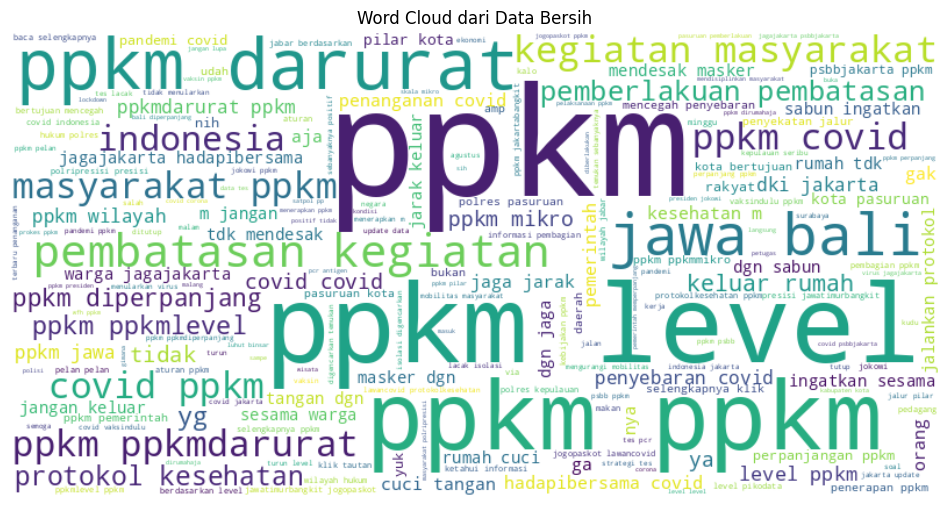

In [7]:
# Gabungkan semua teks mentah menjadi satu string besar
raw_text = " ".join(df['cleaned_text'].astype(str))

# Gunakan wordcloud untuk visualisasi distribusi kata
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(raw_text)

# Plot wordcloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Data Bersih')
plt.show()

Dapat dilihat bahwa sudah tidak ada lagi (setidaknya hampir semua) stopword dan kata kata kurang bermakna lainnya, menyisakan kata kata yang cukup menjadi kunci dalam data training.

# Tokenisasi, Sequencing, dan Pembagian Data

## Tokenisasi dan Padding Data

In [8]:
vocab_size = 20000    # vocab size -> semakin banyak akan membebani model,
                      #               tetapi membantu akurasi (terkait OOV ratio)

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Penentuan max length untuk tiap sequence guna mengoptimasi penilaian model
lengths = [len(s) for s in sequences]
maxlen = int(np.mean(lengths))

# Aplikasi max length pada sequence yang telah di-padding
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

# Hitung total token dan rasio dari OOV token
total_tokens = sum(len(seq) for seq in sequences)
oov_tokens = sum(seq.count(1) for seq in sequences)  # index 1 biasanya OOV

## Data Label Encoding

In [10]:
labels = df['sentiment'].apply(lambda x: 1 if x == 'Positif' else 0).values
labels = labels.reshape(-1, 1)

# Cek distribusi label
unique, counts = np.unique(labels, return_counts=True)

# Jika data tidak seimbang, lakukan oversampling pada kelas minoritas
ros = RandomOverSampler(random_state=42)
x_bal, y_bal = ros.fit_resample(padded_sequences, labels)

## Pembagian Dataset

In [11]:
# Bagi data menjadi data train (80%) dan data sisa (20%)
X_train, X_rem, y_train, y_rem = train_test_split(
    x_bal,
    y_bal,
    train_size=0.8,
    random_state=42,
    stratify=y_bal
)

# Bagi data sisa (20%) menjadi 2 bagian untuk test (10%) dan val (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_rem,
    y_rem,
    test_size=0.5,
    random_state=42,
    stratify=y_rem
)

# Hitung weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train.flatten()),
    y=y_train.flatten()
)

# Ubah weight menjadi dictionary
class_weights_dict = dict(enumerate(class_weights))

# --- Verifikasi Hasil ---
print("Pra-pemrosesan Lanjutan Selesai.")
print(f"Bentuk data training: X={X_train.shape}, y={y_train.shape}")
print(f"Bentuk data validasi: X={X_val.shape}, y={y_val.shape}")
print(f"Bentuk data tes     : X={X_test.shape}, y={y_test.shape}")
print(f"OOV ratio           : {oov_tokens / total_tokens:.2%}")

Pra-pemrosesan Lanjutan Selesai.
Bentuk data training: X=(28329, 14), y=(28329,)
Bentuk data validasi: X=(3541, 14), y=(3541,)
Bentuk data tes     : X=(3542, 14), y=(3542,)
OOV ratio           : 4.15%


# Pembangunan Model

## Buat model dengan arsitektur SimpleRNN

In [12]:
# Arsitektur dengan SimpleRNN
model = Sequential([
    # Input layer menggunakan batas panjang sequence
    Input(shape=(maxlen,)),

    # Layer Embedding
    Embedding(input_dim=vocab_size, output_dim=64),

    # Menggunakan LSTM
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),

    # Menambah Dense Layer
    Dense(32, activation='relu'),
    Dropout(0.2),

    # Layer output 1 untuk klasifikasi
    Dense(1, activation='sigmoid')
])

# Menampilkan ringkasan arsitektur model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 14, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,293,505 (4.93 MB)

 Trainable params: 1,293,505 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

## Kompilasi Model dengan Optimizer Adam

In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.0001), # Di sini menggunakan learning rate 10x slower than default
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Buat mekanisme early stopping yang berfokus pada tingkat val accuracy agar tidak overfitting
ES = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)

# Data Training

In [14]:
print("\nMemulai proses training model...")
history = model.fit(
    X_train, y_train,
    epochs=50,                      # Jumlah epoch maksimal
    validation_data=(X_val, y_val),
    callbacks=[ES],
    verbose=2,                      # Menampilkan log untuk setiap epoch
    class_weight=class_weights_dict
)
print("Training model selesai.")


Memulai proses training model...
Epoch 1/50
886/886 - 29s - 33ms/step - accuracy: 0.7613 - loss: 0.5066 - val_accuracy: 0.8921 - val_loss: 0.2757
Epoch 2/50
886/886 - 23s - 26ms/step - accuracy: 0.9059 - loss: 0.2581 - val_accuracy: 0.9232 - val_loss: 0.2053
Epoch 3/50
886/886 - 24s - 27ms/step - accuracy: 0.9354 - loss: 0.1923 - val_accuracy: 0.9334 - val_loss: 0.1737
Epoch 4/50
886/886 - 40s - 46ms/step - accuracy: 0.9490 - loss: 0.1514 - val_accuracy: 0.9424 - val_loss: 0.1564
Epoch 5/50
886/886 - 24s - 28ms/step - accuracy: 0.9600 - loss: 0.1245 - val_accuracy: 0.9435 - val_loss: 0.1504
Epoch 6/50
886/886 - 23s - 27ms/step - accuracy: 0.9656 - loss: 0.1047 - val_accuracy: 0.9480 - val_loss: 0.1513
Epoch 7/50
886/886 - 41s - 47ms/step - accuracy: 0.9712 - loss: 0.0895 - val_accuracy: 0.9480 - val_loss: 0.1583
Epoch 8/50
886/886 - 24s - 27ms/step - accuracy: 0.9745 - loss: 0.0774 - val_accuracy: 0.9424 - val_loss: 0.1757
Epoch 9/50
886/886 - 24s - 27ms/step - accuracy: 0.9772 - loss

# Visualisasi Hasil

## Loss vs Accuracy

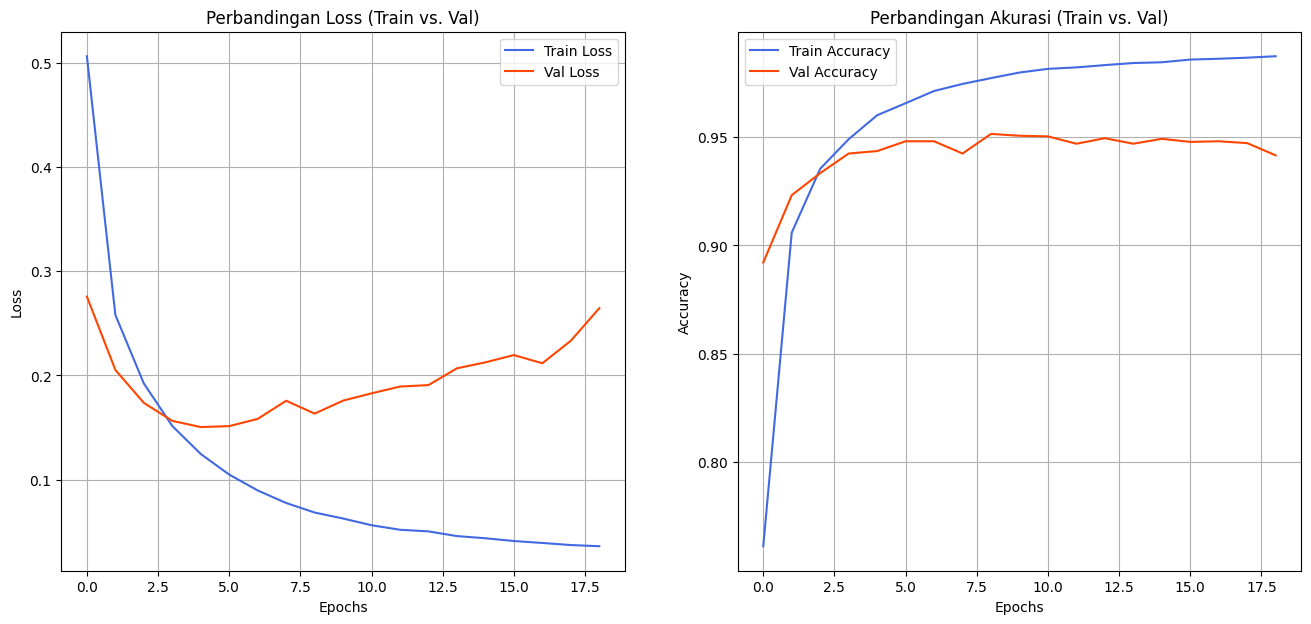

In [15]:
# Ubah history menjadi Pandas DataFrame
history_df = pd.DataFrame(history.history)

# Membuat canvas dengan 2 subplot berdampingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Loss
ax1.set_title('Perbandingan Loss (Train vs. Val)')
ax1.plot(history_df['loss'], label='Train Loss', color='royalblue')
ax1.plot(history_df['val_loss'], label='Val Loss', color='orangered')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot 2: Akurasi
ax2.set_title('Perbandingan Akurasi (Train vs. Val)')
ax2.plot(history_df['accuracy'], label='Train Accuracy', color='royalblue')
ax2.plot(history_df['val_accuracy'], label='Val Accuracy', color='orangered')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()

## Evaluasi Model

In [16]:
# Mengevaluasi model pada X_test dan y_test
print("Mengevaluasi model pada Test Set...")
loss, accuracy = model.evaluate(X_test, y_test)

print(f"\nTest Loss     : {100 * loss:.2f}%")
print(f"Test Accuracy : {100 * accuracy:.2f}%")

Mengevaluasi model pada Test Set...
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9444 - loss: 0.1895

Test Loss     : 17.92%
Test Accuracy : 94.64%


## Hasil Prediksi dari Data Training

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Pred min  : 0.00%
Pred max  : 100.00%
Pred mean : 47.65%

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.92      0.98      0.95      1771
     Positif       0.97      0.92      0.95      1771

    accuracy                           0.95      3542
   macro avg       0.95      0.95      0.95      3542
weighted avg       0.95      0.95      0.95      3542


Confusion Matrix:


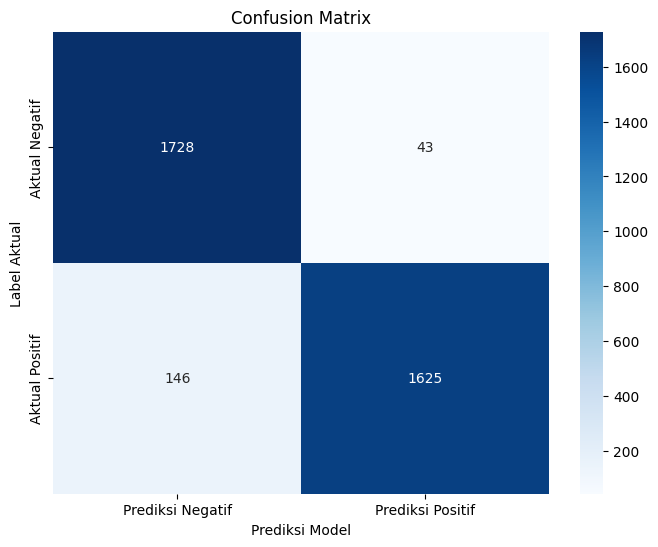

In [17]:
# 1. Membuat prediksi pada data tes
y_pred_probs = model.predict(X_test)
print(f"Pred min  : {100 * y_pred_probs.min():.2f}%")
print(f"Pred max  : {100 * y_pred_probs.max():.2f}%")
print(f"Pred mean : {100 * y_pred_probs.mean():.2f}%")

# Model akan mengeluarkan probabilitas, gunakan rata rata sebagai titik tengah positif-negatif
y_pred = (y_pred_probs > y_pred_probs.mean()).astype(int)

# 2. Menampilkan Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negatif', 'Positif']))

# 3. Menampilkan Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Prediksi Negatif', 'Prediksi Positif'],
    yticklabels=['Aktual Negatif', 'Aktual Positif']
)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Aktual')
plt.title('Confusion Matrix')
plt.show()

# Data Prediction

In [18]:
# Fungsi untuk memprediksi sentimen dari satu kalimat teks mentah
def predict_sentiment(text):
    # 1. Bersihkan teks input
    clean_text = cleaning(text)

    # 2. Tokenisasi teks yang sudah bersih
    sequence = tokenizer.texts_to_sequences([clean_text])

    # 3. Padding sekuens
    padded_sequence = pad_sequences(sequence, maxlen=maxlen, padding='post', truncating='post')

    # 4. Lakukan prediksi dengan model
    prediction_prob = model.predict(padded_sequence, verbose=0)

    # 5. Interpretasi hasil probabilitas
    score = prediction_prob[0][0]
    if score > y_pred_probs.mean():
        return "Positif", score
    else:
        return "Negatif", score

# --- Daftar Kalimat Baru untuk Diuji ---
kalimat_baru = [
    "Kebijakan PPKM darurat terbukti sangat efektif menekan laju penyebaran virus corona.", # Positif +
    "Saya mendukung penuh program vaksinasi pemerintah untuk mencapai kekebalan komunal.",  # Positif +
    "Semoga perpanjangan masa PPKM kali ini membawa dampak baik bagi kita semua.",          # Positif
    "Aturan pembatasan ini cukup membantu mengurangi keramaian di pusat perbelanjaan.",     # Positif
    "Ada baiknya masyarakat mengikuti anjuran pemerintah demi kebaikan bersama.",           # Positif
    "Aturan PPKM yang sering berubah-ubah membuat sebagian masyarakat menjadi bingung.",    # Negatif
    "Kasihan melihat pedagang kaki lima yang pendapatannya menurun drastis.",               # Negatif
    "Kebijakan PPKM ini gagal total dan hanya menyengsarakan rakyat kecil.",                # Negatif -
    "Tolak perpanjangan PPKM, ekonomi masyarakat semakin hancur dan menderita.",            # Negatif -
    "Pemerintah tidak adil, bantuan sosial untuk warga terdampak sangat lambat.",           # Negatif -
]

# --- Lakukan Prediksi untuk Setiap Kalimat ---
print("--- Hasil Prediksi Sentimen untuk Kalimat Baru ---")
for kalimat in kalimat_baru:
    label, skor = predict_sentiment(kalimat)
    print(f"Kalimat: '{kalimat}'")
    print(f"  -> Prediksi: {label} (Skor: {skor:.4f})\n")

--- Hasil Prediksi Sentimen untuk Kalimat Baru ---
Kalimat: 'Kebijakan PPKM darurat terbukti sangat efektif menekan laju penyebaran virus corona.'
  -> Prediksi: Positif (Skor: 0.9970)

Kalimat: 'Saya mendukung penuh program vaksinasi pemerintah untuk mencapai kekebalan komunal.'
  -> Prediksi: Positif (Skor: 0.8536)

Kalimat: 'Semoga perpanjangan masa PPKM kali ini membawa dampak baik bagi kita semua.'
  -> Prediksi: Positif (Skor: 0.9980)

Kalimat: 'Aturan pembatasan ini cukup membantu mengurangi keramaian di pusat perbelanjaan.'
  -> Prediksi: Positif (Skor: 0.9995)

Kalimat: 'Ada baiknya masyarakat mengikuti anjuran pemerintah demi kebaikan bersama.'
  -> Prediksi: Positif (Skor: 0.6155)

Kalimat: 'Aturan PPKM yang sering berubah-ubah membuat sebagian masyarakat menjadi bingung.'
  -> Prediksi: Negatif (Skor: 0.0885)

Kalimat: 'Kasihan melihat pedagang kaki lima yang pendapatannya menurun drastis.'
  -> Prediksi: Negatif (Skor: 0.0021)

Kalimat: 'Kebijakan PPKM ini gagal total dan 